In [1]:
import os
import io
import h5py
import torch
import ipywidgets
import numpy as np
from torch import nn
from PIL import Image
from IPython import display
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from transformers import XLNetTokenizer, XLNetModel
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

checkpoint = torch.load("/kaggle/input/text-to-image-xlnet-pytorch/checkpoint.pth", map_location=device)
models = checkpoint.get("models")

In [3]:
class TextEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.transformer = XLNetModel.from_pretrained("xlnet-base-cased")

    def forward(self, input_ids, token_type_ids, attention_mask):
        hidden = self.transformer(
            input_ids=input_ids,
            token_type_ids=token_type_ids,
            attention_mask=attention_mask
        ).last_hidden_state
        context = hidden.mean(dim=1)
        context = context.view(*context.shape, 1, 1)
        return context
    

class Generator(nn.Module):
    def __init__(self, nz=100, nt=768, nc=3, ngf=64):
        super().__init__()
        
        self.layer1 = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz + nt, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            # nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
        )

            # Completed - TODO: check out paper's code and add layers if required

            ##there are more conv2d layers involved here in 
            # https://github.com/reedscot/icml2016/blob/master/main_cls.lua
        self.layer2 = nn.Sequential(
            nn.Conv2d(ngf*8,ngf*2,1,1),
            nn.Dropout2d(inplace=True),            
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # nn.SELU(True),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(ngf*2,ngf*2,3,1,1),
            nn.Dropout2d(inplace=True),            
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # nn.SELU(True),
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(ngf*2,ngf*8,3,1,1),
            nn.Dropout2d(inplace=True),            
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(inplace=True),
            # nn.SELU(True),
        )
        self.layer5 = nn.Sequential(
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),   
            nn.BatchNorm2d(ngf * 4),
            # nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
        )
            
            # Completed - TODO: check out paper's code and add layers if required
            
            ##there are more conv2d layers involved here in 
            # https://github.com/reedscot/icml2016/blob/master/main_cls.lua
            
        self.layer6 = nn.Sequential(
            nn.Conv2d(ngf*4,ngf,1,1),
            nn.Dropout2d(inplace=True),            
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # nn.SELU(True),
        )
        self.layer7 = nn.Sequential(
            nn.Conv2d(ngf,ngf,3,1,1),
            nn.Dropout2d(inplace=True),            
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # nn.SELU(True),
        )
        self.layer8 = nn.Sequential(
            nn.Conv2d(ngf,ngf*4,3,1,1),
            nn.Dropout2d(inplace=True),            
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # nn.SELU(True),
        )
        self.layer9 = nn.Sequential(  
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # nn.SELU(True),
            
            # state size. (ngf*2) x 16 x 16
        )
        self.layer10 = nn.Sequential(
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # nn.SELU(True),

            # state size. (ngf) x 32 x 32
        )
        self.layer11 = nn.Sequential(
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )
  
    def forward(self,noise,encoded_text):
        x = torch.cat([noise,encoded_text],dim=1)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.layer9(x)
        x = self.layer10(x)
        x = self.layer11(x)
        return x
    

class Discriminator(nn.Module):
    def __init__(self, nc=3, ndf=64, nt=768):
        super().__init__()
        self.layer1 = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.layer2 = nn.Sequential(
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.layer3 = nn.Sequential(
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.layer4 = nn.Sequential(
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),

            nn.Conv2d(ndf*8,ndf*2,1,1),
            # nn.Dropout2d(inplace=True),            
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.layer5 = nn.Sequential(

            nn.Conv2d(ndf*2,ndf*2,3,1,1),
            # nn.Dropout2d(inplace=True),            
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.layer6 = nn.Sequential(

            nn.Conv2d(ndf*2,ndf*8,3,1,1),
            # nn.Dropout2d(inplace=True),            
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.concat_image_n_text = nn.Sequential(
            nn.Conv2d(ndf * 8 + nt, ndf * 8, 1, 1, 0, bias=False), ## TODO: Might want to change the kernel size and stride
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(ndf * 8, 2, 4, 1, 0, bias=False),
            nn.Flatten(start_dim=1)
        )

    def forward(self, x, encoded_text):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
#         print(x.shape)
        x = torch.cat([x, encoded_text.repeat(1, 1, 4, 4)], dim=1)
        x = self.concat_image_n_text(x)
        return x

In [4]:
te =  TextEncoder()
gen = Generator()
disc = Discriminator()

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetModel: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
te.load_state_dict(models["text_encoder"])
te.eval()

gen.load_state_dict(models["generator"])
gen.eval()

disc.load_state_dict(models["discriminator"])
disc.eval()

models = {
    "text_encoder": te.to(device),
    "generator": gen.to(device),
    "discriminator": disc.to(device)
}

In [6]:
tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")
max_seq_len = 85

def prepareText(text):
        input_ids = tokenizer.encode(text)
        token_type_ids = [0] * (len(input_ids) - 1) + [1]
        attention_mask = [1] * len(token_type_ids)
        return {
                    "input_ids": input_ids,
                    "token_type_ids": token_type_ids,
                    "attention_mask": attention_mask
        }

def padTokens(text_dict):
        pad_len = max_seq_len - sum(text_dict["attention_mask"])
        text_dict['input_ids'] =  [5] * pad_len + text_dict['input_ids']
        text_dict['token_type_ids'] =  [2] * pad_len + text_dict['token_type_ids']
        text_dict['attention_mask'] = [0] * pad_len + text_dict['attention_mask']   
        return text_dict
    
def preprocessText(text):
    return padTokens(prepareText(text))

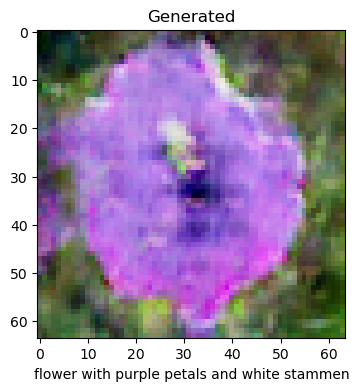

In [7]:
def visualize(image, text, tokenizer=None, ax = None, title = None):
    if ax is None: _, ax = plt.subplots(1, 1, figsize = (4, 4))
    if title: ax.set_title(title)
    ax.imshow(image.permute(1, 2, 0))
    ax.set_xlabel(text)

text = "flower with purple petals and white stammen"
params = preprocessText(text)
for key in params:
    params[key] = torch.tensor(params[key], device=device)[None]

enc_text = models["text_encoder"](**params)
noise = torch.randn((1, 100, 1, 1), device=device)
gen_image = models["generator"](noise, enc_text).detach().squeeze().cpu()

transform = transforms.ToPILImage()
image = transform(gen_image)
image.save("/kaggle/working/image.jpg")


visualize(gen_image, text, None, None, "Generated")
plt.show()

In [8]:
def visualize(image, text, tokenizer=None, ax = None, title = None):
    if ax is None: _, ax = plt.subplots(1, 1, figsize = (10, 10))
    if title: ax.set_title(title)
    ax.imshow(image.permute(1, 2, 0))
    if tokenizer== None:
        pass
    else:
        ax.set_xlabel(tokenizer.decode([t for t in text["input_ids"] if t != 5]))
        
idx = np.random.randint(len(train_dataset))
(image, text), _ = train_dataset[idx]
params = {}
for key in text:
    params[key] = torch.tensor(text[key], device=device)[None]
for key in models:
     models[key].eval()
enc_text = models["text_encoder"](**params)
noise = torch.randn((1, 100, 1, 1), device=device)
gen_image = models["generator"](noise, enc_text).detach().squeeze().cpu()
_, axs = plt.subplots(1, 2, figsize=(5, 5))
visualize(image, text, train_dataset.tokenizer, axs[0], "Right")
visualize(gen_image, text, None, axs[1], "Generated")
plt.show()

NameError: name 'train_dataset' is not defined

In [22]:
"""transform = T.ToPILImage()

# convert the tensor to PIL image using above transform
images = transform(gen_image)
images = images.resize((299, 299))
images = np.array(images)
images = np.array([images])
images.shape"""

(1, 299, 299, 3)

### Super Resolution

In [23]:
import os
import time
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

In [24]:
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"

In [27]:
def preprocess_image(image_path):
    """ Loads image from path and preprocesses to make it model ready
        Args:
        image_path: Path to the image file
    """
    hr_image = tf.image.decode_image(tf.io.read_file(image_path))
    # If PNG, remove the alpha channel. The model only supports
    # images with 3 color channels.
    if hr_image.shape[-1] == 4:
        hr_image = hr_image[...,:-1]
    hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
    hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
    hr_image = tf.cast(hr_image, tf.float32)
    return tf.expand_dims(hr_image, 0)

%matplotlib inline
def plot_image(image, title=""):
    """
    Plots images from image tensors.
    Args:
        image: 3D image tensor. [height, width, channels].
        title: Title to display in the plot.
    """
    image = np.asarray(image)
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
    plt.imshow(image)
    plt.axis("off")
    plt.title(title)

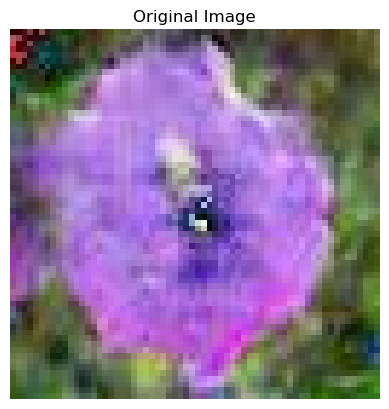

In [47]:
hr_image = preprocess_image("/kaggle/working/image.jpg")
plot_image(tf.squeeze(hr_image), title="Original Image")

In [48]:
# model = hub.load(SAVED_MODEL_PATH)

Downloaded https://tfhub.dev/captain-pool/esrgan-tf2/1, Total size: 20.60MB



In [28]:
"""sr_image = model(hr_image)
sr_image = tf.squeeze(sr_image)
plot_image(tf.squeeze(sr_image), title="Super Resolution")"""

'sr_image = model(hr_image)\nsr_image = tf.squeeze(sr_image)\nplot_image(tf.squeeze(sr_image), title="Super Resolution")'

### Generate results

In [10]:
class TrainDataset:
    def __init__(self, dataset_root, kernel_root):
        self.tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")

        if os.path.exists(os.path.join(kernel_root, "data.npy")):
            self.data = np.load(os.path.join(kernel_root, "data.npy"), allow_pickle=True)
        else:
            f = h5py.File(os.path.join(dataset_root, "data", "flowers", "flowers.hdf5"), mode="r")
            self.data = self.prepareData(f['train'])
        np.save('data.npy', self.data)
        self.max_seq_len = max(map(lambda x: len(x["text"]["input_ids"]), self.data))

        self.transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(degrees=(90, 90)),
            transforms.RandomRotation(degrees=(180, 180)),
            transforms.RandomRotation(degrees=(270, 270)),
            transforms.RandomVerticalFlip(p=1),
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
        ])

    def prepareData(self, data):
        preparedData = []
        for idx, img_name in enumerate(tqdm(data)):
            image = np.array(Image.open(io.BytesIO(bytes(np.array(data[img_name]['img'])))).resize((256,256)))
            text = np.array(data[img_name]['txt']).item().strip()
            input_ids = self.tokenizer.encode(text)
            token_type_ids = [0] * (len(input_ids) - 1) + [1]
            attention_mask = [1] * len(token_type_ids)
            preparedData.append({
                "image": image,
                "text": {
                    "input_ids": input_ids,
                    "token_type_ids": token_type_ids,
                    "attention_mask": attention_mask
                },
            })
        return preparedData

    def padTokens(self, text_dict):
        pad_len = self.max_seq_len - sum(text_dict["attention_mask"])
        text_dict['input_ids'] =  [5] * pad_len + text_dict['input_ids'] # <pad> = 5
        text_dict['token_type_ids'] =  [2] * pad_len + text_dict['token_type_ids']
        text_dict['attention_mask'] = [0] * pad_len + text_dict['attention_mask']   
        return text_dict

    @staticmethod
    def collate_fn_module(batch, idx):
        images, texts = [], {}
        for data in batch:
            images.append(data[idx][0])
            for key in data[idx][1]:
                if key not in texts:
                    texts[key] = []
                texts[key].append(data[0][1][key])

        images = torch.stack(images).to(device)
        for key in texts:
            texts[key] = torch.tensor(texts[key]).to(device)
        return images, texts

    def collate_fn(self, batch):
        right_images, right_texts = self.collate_fn_module(batch, 0)
        wrong_images, wrong_texts = self.collate_fn_module(batch, 1)
        return (right_images, right_texts), (wrong_images, wrong_texts)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, right_idx):
        right_data = self.data[right_idx].copy()
        right_image = self.transforms(Image.fromarray(right_data["image"]))
        right_text = self.padTokens(right_data["text"].copy())

        wrong_idx = np.random.choice([(i) for i in range(len(self.data)) if i != right_idx])
        wrong_data = self.data[wrong_idx].copy()
        wrong_image = self.transforms(Image.fromarray(wrong_data["image"]))
        wrong_text = self.padTokens(wrong_data["text"].copy())
        return (right_image, right_text), (wrong_image, wrong_text)

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
dataset_root = os.path.join("/", "kaggle", "input", "flowershd5dataset")
kernel_root = os.path.join("/", "kaggle", "input", "text-to-image-xlnet-pytorch")

In [12]:
%%time
train_dataset = TrainDataset(dataset_root, kernel_root)

CPU times: user 12.6 s, sys: 39 s, total: 51.6 s
Wall time: 2min 15s


In [13]:
len(train_dataset)

29390

In [14]:
train_dataset[0]

((tensor([[[0.4588, 0.3725, 0.3412,  ..., 0.0510, 0.0471, 0.0588],
           [0.4824, 0.4392, 0.4353,  ..., 0.0510, 0.0431, 0.0510],
           [0.4510, 0.4784, 0.4863,  ..., 0.0510, 0.0431, 0.0549],
           ...,
           [0.4000, 0.4588, 0.4588,  ..., 0.1922, 0.2392, 0.2784],
           [0.4118, 0.4471, 0.6235,  ..., 0.2000, 0.2510, 0.2863],
           [0.4941, 0.5569, 0.7294,  ..., 0.2078, 0.2471, 0.2706]],
  
          [[0.4431, 0.3725, 0.3882,  ..., 0.0588, 0.0549, 0.0667],
           [0.4902, 0.4549, 0.4627,  ..., 0.0588, 0.0510, 0.0588],
           [0.4863, 0.5255, 0.5333,  ..., 0.0588, 0.0510, 0.0627],
           ...,
           [0.4157, 0.4549, 0.4588,  ..., 0.1176, 0.1490, 0.1843],
           [0.4431, 0.4471, 0.5882,  ..., 0.1216, 0.1647, 0.2000],
           [0.5294, 0.5490, 0.6667,  ..., 0.1333, 0.1686, 0.1961]],
  
          [[0.3176, 0.1843, 0.1412,  ..., 0.0078, 0.0039, 0.0157],
           [0.3176, 0.2078, 0.2000,  ..., 0.0078, 0.0000, 0.0078],
           [0.2745, 0.

100%|██████████| 99/99 [04:24<00:00,  2.67s/it]


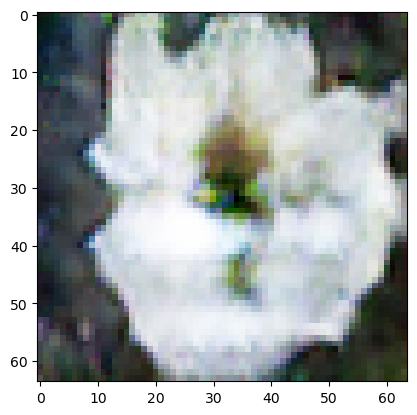

In [16]:
from tqdm import tqdm

os.mkdir("/kaggle/working/results")
os.mkdir("/kaggle/working/results/original")
os.mkdir("/kaggle/working/results/generated")


def visualize(image, text, tokenizer=None, ax = None, title = None):
    if ax is None: _, ax = plt.subplots(1, 1, figsize = (10, 10))
    if title: ax.set_title(title)
    ax.imshow(image.permute(1, 2, 0))

for i in tqdm(range(1, 100)):
    idx = np.random.randint(len(train_dataset))
    (image, text), _ = train_dataset[idx]
    params = {}
    for key in text:
        params[key] = torch.tensor(text[key], device=device)[None]
    for key in models:
         models[key].eval()
    enc_text = models["text_encoder"](**params)
    noise = torch.randn((1, 100, 1, 1), device=device)
    gen_image = models["generator"](noise, enc_text).detach().squeeze().cpu()
    plt.imshow(image.permute(1, 2, 0))
    plt.savefig(f"/kaggle/working/results/original/output_{i}")
    plt.imshow(gen_image.permute(1, 2, 0))
    plt.savefig(f"/kaggle/working/results/generated/output_{i}")

### Inception Score

In [26]:
# calculate inception score with Keras
from math import floor
from numpy import ones
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import std
from numpy import exp
import numpy as np
import torchvision.transforms as T
from PIL import Image
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
 
# assumes images have the shape 299x299x3, pixels in [0,255]
def calculate_inception_score(images, n_split=10, eps=1E-16):
    # load inception v3 model
    model = InceptionV3()
    # convert from uint8 to float32
    processed = images.astype('float32')
    # pre-process raw images for inception v3 model
    processed = preprocess_input(processed)
    # predict class probabilities for images
    yhat = model.predict(processed)
    # enumerate splits of images/predictions
    scores = list()
    n_part = floor(images.shape[0] / n_split)
    for i in range(n_split):
        # retrieve p(y|x)
        ix_start, ix_end = i * n_part, i * n_part + n_part
        p_yx = yhat[ix_start:ix_end]
        # calculate p(y)
        p_y = expand_dims(p_yx.mean(axis=0), 0)
        # calculate KL divergence using log probabilities
        kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
        # sum over classes
        sum_kl_d = kl_d.sum(axis=1)
        # average over images
        avg_kl_d = mean(sum_kl_d)
        # undo the log
        is_score = exp(avg_kl_d)
        # store
        scores.append(is_score)
    # average across images
    is_avg, is_std = mean(scores), std(scores)
    return is_avg, is_std

# define a transform to convert a tensor to PIL image
transform = T.ToPILImage()

def compute_inception_score():
    filenames = os.listdir("/kaggle/working/results/generated")
    os.chdir("/kaggle/working/results/generated")
    images = []
    
    for name in filenames:
        img = Image.open(name).convert('RGB')
        img = img.resize((299, 299))
        images.append(np.array(img))
    
    images = np.array(images)
    is_avg, is_std = calculate_inception_score(images)
    print('score', is_avg, is_std)
    
compute_inception_score()

4/4 [==============================] - 13s 3s/step
score 1.8128881 0.20229296


### Compute metrics over generated data

In [40]:
!pip3 install sewar

  Preparing metadata (setup.py) ... done
  Created wheel for sewar: filename=sewar-0.4.5-py3-none-any.whl size=10608 sha256=233cb63de505972a7b451d09fcd64e8edc25f81bb22531ffd149106f5c2bdf5d
  Stored in directory: /root/.cache/pip/wheels/e4/76/b4/ba83281aee227848de59e42538691d0cea0d7f4f1331880892
Successfully built sewar


In [44]:
import numpy as np
from keras.applications import VGG16
from keras.preprocessing import image
from tensorflow.keras.utils import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from sklearn.metrics.pairwise import cosine_similarity

# Load the pre-trained VGG-16 model
model = VGG16(weights='imagenet', include_top=False)

# Define a function to extract the VGG-16 features from an image
def extract_features(img_path):
    img = load_img(img_path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x)
    features = features.flatten()
    return features


58889256/58889256 [==============================] - 2s 0us/step


In [16]:
f = h5py.File(os.path.join("/kaggle/input/flowershd5dataset", "data", "flowers", "flowers.hdf5"), mode="r")

In [23]:
f["train"]['image_00001_0']['txt'].item().strip()

AttributeError: 'Dataset' object has no attribute 'item'

In [24]:
d = f["train"]

for idx, img_name in enumerate(tqdm(d)):
            image = np.array(Image.open(io.BytesIO(bytes(np.array(d[img_name]['img'])))).resize((256,256)))
            text = np.array(d[img_name]['txt']).item().strip()

100%|██████████| 29390/29390 [07:09<00:00, 68.36it/s]


In [42]:
text

{'input_ids': [5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  52,
  7544,
  51,
  392,
  10516,
  25702,
  21,
  24,
  3493,
  17,
  2742,
  23,
  5356,
  9,
  4,
  3],
 'token_type_ids': [2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1],
 'attention_mask': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
 

In [45]:
# VSS

import os

org_path = "/kaggle/working/results/original"
gen_path = "/kaggle/working/results/generated"

file_names = os.listdir("/kaggle/working/results/original")

VSS = []
for file_name in file_names:
    org_feat = extract_features(org_path + "/" + file_name)
    gen_feat = extract_features(gen_path + "/" + file_name)
    similarity = cosine_similarity([org_feat], [gen_feat])
    VSS.append(similarity)

1/1 [==============================] - 0s 259ms/step


In [18]:
print("Mean Visual Semantic Similarity (VSS) : ", np.mean(VSS))

Mean Visual Semantic Similarity (VSS) :  0.60557866


In [ ]:
# calculate inception score with Keras
from math import floor
from numpy import ones
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import std
from numpy import exp
import numpy as np
import torchvision.transforms as T
from PIL import Image
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
 
# assumes images have the shape 299x299x3, pixels in [0,255]
def calculate_inception_score(images, n_split=10, eps=1E-16):
    # load inception v3 model
    model = InceptionV3()
    # convert from uint8 to float32
    processed = images.astype('float32')
    # pre-process raw images for inception v3 model
    processed = preprocess_input(processed)
    # predict class probabilities for images
    yhat = model.predict(processed)
    # enumerate splits of images/predictions
    scores = list()
    n_part = floor(images.shape[0] / n_split)
    for i in range(n_split):
        # retrieve p(y|x)
        ix_start, ix_end = i * n_part, i * n_part + n_part
        p_yx = yhat[ix_start:ix_end]
        # calculate p(y)
        p_y = expand_dims(p_yx.mean(axis=0), 0)
        # calculate KL divergence using log probabilities
        kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
        # sum over classes
        sum_kl_d = kl_d.sum(axis=1)
        # average over images
        avg_kl_d = mean(sum_kl_d)
        # undo the log
        is_score = exp(avg_kl_d)
        # store
        scores.append(is_score)
    # average across images
    is_avg, is_std = mean(scores), std(scores)
    return is_avg, is_std

# define a transform to convert a tensor to PIL image
transform = T.ToPILImage()

def compute_inception_score():
    filenames = os.listdir("/kaggle/working/results/generated")
    os.chdir("/kaggle/working/results/generated")
    images = []
    
    for name in filenames:
        img = Image.open(name)
        img = img.resize((299, 299))
        images.append(np.array(img))
    
    images = np.array(images)
    is_avg, is_std = calculate_inception_score(images)
    print('score', is_avg, is_std)
    
compute_inception_score()